In [165]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from IPS import IPS
from AdaIPS_v2 import AdaIPS_S
from getData import getData

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [166]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)
        
        self.t_losses = []
        self.v_losses = []
        

    def forward(self, x):
        x = x.view(-1, 28*28).float()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [167]:
epochs = 5
batch_size = 64


In [168]:

trainloader, trainset, testloader, testset, validationloader, valset = getData('MNIST', batch_size=batch_size)

In [ ]:
def train(model, optimizer, epochs=2):
    print(optimizer)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer

    num_epochs = epochs
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            def closure():
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                return loss

    
            # if i % 100 == 0:                
            #     with torch.no_grad():
            #         for v_i, (v_inputs, v_labels) in enumerate(validationloader):
            #             v_inputs, v_labels = v_inputs.to(device), v_labels.to(device)
            #             v_outputs = model(v_inputs)
            #             v_loss = criterion(v_outputs, v_labels)
                    
            #         print("validation loss", v_loss.item())                   
            #     model.v_losses.append(v_loss.item())
                
            loss = optimizer.step(closure)
            
            if i % 100 == 0:
                print(f'Epoch {epoch+1}, Step {i}, Loss: {loss}')
                model.t_losses.append(loss.item())
            

    print("Training complete.")
    return model

In [170]:
def test(model):
    for i, (inputs, labels) in enumerate(testloader):
        output = model(inputs)
        output = output.argmax(axis=1)
        print(accuracy_score(labels, output.detach().numpy()))

In [171]:
adaIpsModel = SimpleNN().to(device)
adaIpsOptimizer = AdaIPS_S(adaIpsModel.parameters(), T=epochs * (len(trainset)/batch_size), lower_bound=0, beta_1=0.9, beta_2=0.99)
train(adaIpsModel, adaIpsOptimizer, epochs=epochs)

AdaIPS_S (
Parameter Group 0
    T0: 3750.0
    beta_1: 0.9
    beta_2: 0.99
    eps: 1e-08
    lower_bound: 0
)
validation loss 2.3042984008789062
Epoch 1, Step 0, Loss: 2.3016698360443115
validation loss 0.5514998435974121
Epoch 1, Step 100, Loss: 0.4709106385707855
validation loss 0.4125945270061493
Epoch 1, Step 200, Loss: 0.347089558839798
validation loss 0.3389909863471985
Epoch 1, Step 300, Loss: 0.28651461005210876
validation loss 0.34670254588127136
Epoch 1, Step 400, Loss: 0.2797076404094696
validation loss 0.30701926350593567
Epoch 1, Step 500, Loss: 0.2576604187488556
validation loss 0.2751125991344452
Epoch 1, Step 600, Loss: 0.5131370425224304
validation loss 0.2393723726272583
Epoch 1, Step 700, Loss: 0.4194222390651703
validation loss 0.25168439745903015
Epoch 2, Step 0, Loss: 0.3020390272140503
validation loss 0.23605017364025116
Epoch 2, Step 100, Loss: 0.26107552647590637
validation loss 0.21909885108470917
Epoch 2, Step 200, Loss: 0.20124685764312744
validation loss

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [172]:
ipsModel = SimpleNN().to(device)
ipsOptimizer = IPS(ipsModel.parameters(), T=epochs * (len(trainset) / batch_size), lower_bound=0)
train(ipsModel, ipsOptimizer, epochs=5)

IPS (
Parameter Group 0
    T: 3750.0
    lower_bound: 0
)
validation loss 2.3103647232055664
Epoch 1, Step 0, Loss: 2.3211464881896973
validation loss 0.8658219575881958
Epoch 1, Step 100, Loss: 0.6625097393989563
validation loss 0.6923038959503174
Epoch 1, Step 200, Loss: 0.6364613771438599
validation loss 0.5927822589874268
Epoch 1, Step 300, Loss: 0.5152483582496643
validation loss 0.5457530617713928
Epoch 1, Step 400, Loss: 0.5015949010848999
validation loss 0.49801793694496155
Epoch 1, Step 500, Loss: 0.5029101967811584
validation loss 0.4662483036518097
Epoch 1, Step 600, Loss: 0.44109806418418884
validation loss 0.44887757301330566
Epoch 1, Step 700, Loss: 0.48317474126815796
validation loss 0.4370425343513489
Epoch 2, Step 0, Loss: 0.38012370467185974
validation loss 0.43442288041114807
Epoch 2, Step 100, Loss: 0.3745071291923523
validation loss 0.41386711597442627
Epoch 2, Step 200, Loss: 0.5633466839790344
validation loss 0.4005722105503082
Epoch 2, Step 300, Loss: 0.4132254

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [173]:
adamModel = SimpleNN().to(device)
adamOptimizer = torch.optim.Adam(adamModel.parameters(), lr=1e-3)
train(adamModel, adamOptimizer, epochs=5)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
validation loss 2.3065266609191895
Epoch 1, Step 0, Loss: 2.2987923622131348
validation loss 0.510803759098053
Epoch 1, Step 100, Loss: 0.6088573336601257
validation loss 0.32579147815704346
Epoch 1, Step 200, Loss: 0.3271828889846802
validation loss 0.26512518525123596
Epoch 1, Step 300, Loss: 0.17001526057720184
validation loss 0.23001672327518463
Epoch 1, Step 400, Loss: 0.2014327049255371
validation loss 0.21119427680969238
Epoch 1, Step 500, Loss: 0.1849384307861328
validation loss 0.2062223255634308
Epoch 1, Step 600, Loss: 0.20836512744426727
validation loss 0.18642419576644897
Epoch 1, Step 700, Loss: 0.14873246848583221
validation loss 0.18373256921768188
Epoch 2, Step 0, Loss: 0.1383448839187622
validation loss 0.16532620787620544
Epoch 2, Step 100, Loss: 0.1

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [174]:
test(adaIpsModel)
test(ipsModel)
test(adamModel)

0.9565
0.916
0.975


40
40
40


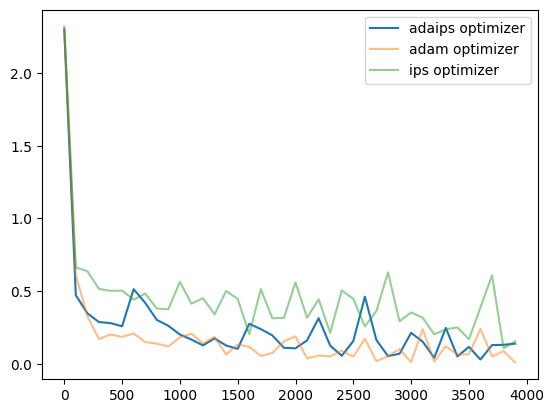

In [183]:

models = [
    (adaIpsModel, 'adaips optimizer'),
    (adamModel, 'adam optimizer'),
    (ipsModel, 'ips optimizer')

]
exclude = []
focus = [adaIpsModel]
interval = 1
for model, optimizer in models:
    if model in exclude: continue
    print(len(model.t_losses))
    plt.plot(
        [i * 100 for i, loss in enumerate(model.t_losses) if i % interval == 0], 
        [loss for i, loss in enumerate(model.t_losses) if i % interval == 0], 
        label=optimizer,
        alpha=0.5 if model not in focus else 1
    )

plt.legend()
plt.show()

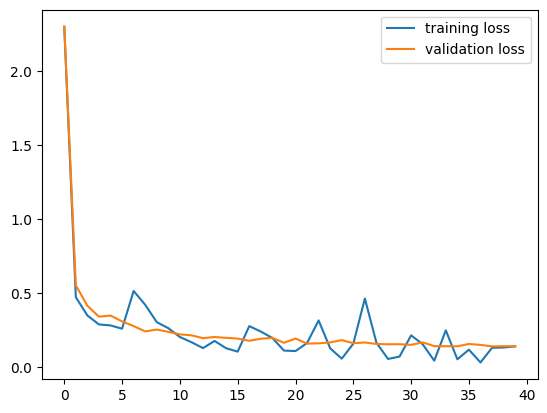

In [181]:

plt.plot([t for t in adaIpsModel.t_losses], label='training loss')
plt.plot([v for v in adaIpsModel.v_losses], label='validation loss')
plt.legend()
plt.show()


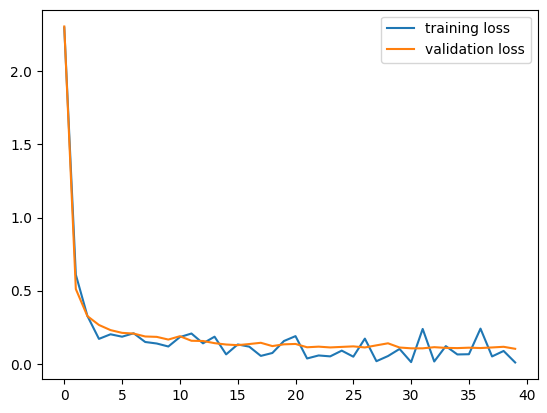

In [182]:
plt.plot([t for t in adamModel.t_losses], label='training loss')
plt.plot([v for v in adamModel.v_losses], label='validation loss')
plt.legend()
plt.show()